In [26]:
import os
import time

import matplotlib
import keras
import pandas as pd
import swifter
import numpy as np
import json

from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
import tensorflow
from IPython.display import display

from app.features.MidiData import MidiData

DTYPE = {
    'canonical_composer': 'category',
    'canonical_title': 'object',
    'split': 'category',
    'year': 'int64',
    'midi_filename': 'object',
    'audio_filename': 'object',
    'duration': 'float64'
}

FEATURES = 1


def number_of_classes(classes):
    return len(classes.canonical_composer.cat.categories)


def get_midi_data(filename):
    return MidiData(os.path.join("/Users/zombre/Documents/Kent/music-neural-network/data/maestro-v2.0.0/", filename))

In [27]:
data = pd.read_json('/Users/zombre/Documents/Kent/music-neural-network/data/maestro-v2.0.0/maestro-v2.0.0.json')
dataset = data.astype(DTYPE)
start_time = time.time()

In [25]:
dataset['midi_data'] = dataset['midi_filename'].swifter.progress_bar().allow_dask_on_strings().apply(get_midi_data)

KeyboardInterrupt: 

In [82]:
import pickle

with open('/Users/zombre/Documents/Kent/music-neural-network/dataset.pickle', 'rb') as f:
    dataset = pickle.load(f)

In [29]:
current_time = time.time()
print(f'Elapsed time: {(current_time - start_time) / 60} minute(s)')


Elapsed time: 0.23224303325017293 minute(s)


In [83]:
def get_notes(midi_data):
    return np.asarray([n["note"] for n in midi_data.notes.notes])


dataset['raw_notes'] = dataset.midi_data.swifter.apply(get_notes)
dataset['raw_notes_count'] = dataset.raw_notes.swifter.apply(lambda a: len(a))

In [31]:
def code_to_label(code):
    return dataset.canonical_composer.cat.categories[code]


def extract_features(features):
    midi_data = features['midi_data']
    return {'Composer': features['canonical_composer'],
            'TempoMax': midi_data.tempos.getMax(), 'TempoMin': midi_data.tempos.getMin(),
            'NoteMax': midi_data.notes.getMax(), 'NoteMin': midi_data.notes.getMin(),
            'TempoRepetition': midi_data.tempos.getRepetition(), 'NoteRepetition': midi_data.notes.getRepetition(),
            'TemposAverageByPartsTime': midi_data.tempos.getAverageByPartsTime(),
            'NotesAverageByPartsTime': midi_data.notes.getAverageByPartsTime()}

,raw_notes_count
count,1061.000000
mean,8804.865221
std,4492.849176
min,2586.000000
25%,4708.000000
50%,8022.000000
75%,12326.000000
max,19572.000000


,raw_notes_count
count,1282.000000
mean,11117.500780
std,8545.336245
min,258.000000
25%,4702.500000
50%,8837.000000
75%,14584.500000
max,50152.000000


,raw_notes_count
0,258
1,732
2,732
3,810
4,1010
...,...
1277,42870
1278,43042
1279,46938
1280,47670


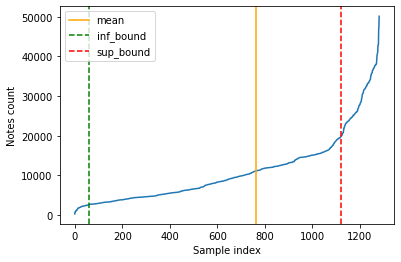

In [84]:
notes_count_mean = dataset.raw_notes_count.mean()
inf_bound = notes_count_mean - 1 * dataset.raw_notes_count.std()
sup_bound = notes_count_mean + 1 * dataset.raw_notes_count.std()

reduced_dataset = dataset[
    (dataset.raw_notes_count >= inf_bound) & (dataset.raw_notes_count <= sup_bound)
].copy()
display(reduced_dataset[["raw_notes_count"]].describe())

stats = pd.DataFrame(
    {"raw_notes_count": dataset.raw_notes_count.sort_values(ignore_index=True),}
)
plot = stats.plot(style={"inf_bound": "--", "sup_bound": "--"})
plot.set(xlabel='Sample index', ylabel='Notes count')

mean_index = stats.index[stats.raw_notes_count >= notes_count_mean][0]
inf_bound_index = stats.index[stats.raw_notes_count >= inf_bound][0]
sup_bound_index = stats.index[stats.raw_notes_count >= sup_bound][0]
mean_line = plot.axvline(x=mean_index, c="orange", label="mean")

# Draw separator lines for selected subset
inf_bound_line = plot.axvline(x=inf_bound_index, c="green", ls="--", label="inf_bound")
sup_bound_line = plot.axvline(x=sup_bound_index, c="red", ls="--", label="sup_bound")
plot.legend(handles=[mean_line, inf_bound_line, sup_bound_line])

# Extract stats for the notes counts
display(dataset[["raw_notes_count"]].describe())
display(stats)

In [180]:
max_notes_count = reduced_dataset.raw_notes_count.max()
min_notes_count = reduced_dataset.raw_notes_count.min()

def pad_array(a):
    return np.pad(a, (0, max_notes_count - a.shape[0]), mode="constant")

# Pad notes array to max length
reduced_dataset["padded_notes"] = reduced_dataset.raw_notes.swifter.apply(pad_array)

In [181]:
def format_data(data_to_format):
    train = data_to_format[data_to_format.split == 'train']
    test = data_to_format[data_to_format.split == 'test']
    validation = data_to_format[data_to_format.split == 'validation']
    x_split_train = np.vstack(train['padded_notes']).reshape(len(train.index), -1, FEATURES)
    y_split_train = np.asarray(train['canonical_composer'].cat.codes)
    x_split_test = np.vstack(test['padded_notes']).reshape(len(test.index), -1, FEATURES)
    y_split_test = np.asarray(test['canonical_composer'].cat.codes)
    x_split_validation = np.vstack(validation['padded_notes']).reshape(len(validation.index), -1, FEATURES)
    y_split_validation = np.asarray(validation['canonical_composer'].cat.codes)

    return x_split_train, y_split_train, x_split_test, y_split_test, x_split_validation, y_split_validation


NUM_CLASSES = number_of_classes(dataset)

In [182]:
x_train, y_train, x_test, y_test, x_validation, y_validation = format_data(reduced_dataset)

In [207]:
def build_model(input_shape, output_shape):
    print(f'Input shape : {input_shape}')
    print(f'Output shape : {output_shape}')
    
    model_to_build = keras.Sequential(
        [
            keras.layers.Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=input_shape),
            keras.layers.AveragePooling1D(pool_size=10, strides=2),
            keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu'),
            keras.layers.AveragePooling1D(pool_size=10, strides=2),
            keras.layers.Conv1D(filters=128, kernel_size=10, activation='relu'),
            keras.layers.Flatten(),
            keras.layers.Dense(output_shape),
        ]
    )
    model_to_build.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_to_build.summary()
    return model_to_build

In [208]:
model = build_model(x_train[0].shape, NUM_CLASSES)

Input shape : (19572, 1)
Output shape : 61
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          (None, 19570, 512)        2048      
_________________________________________________________________
average_pooling1d_31 (Averag (None, 9781, 512)         0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 9777, 256)         655616    
_________________________________________________________________
average_pooling1d_32 (Averag (None, 4884, 256)         0         
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 4875, 128)         327808    
_________________________________________________________________
flatten_37 (Flatten)         (None, 624000)            0         
_________________________________________________________________
dense_42 (

In [196]:
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [209]:
checkpoint = keras.callbacks.ModelCheckpoint(f'./models/model.h5',
                                             monitor='val_accuracy', verbose=2,
                                             save_best_only=True, mode='max')
tb_callback = tensorflow.keras.callbacks.TensorBoard(log_dir='./logs/',
                                             profile_batch=(0, 32))
history = model.fit(x_train, y_train, batch_size=8, epochs=10,
                    callbacks=[checkpoint],
                    validation_data=(x_test, y_test), use_multiprocessing=True)
loss, accuracy = model.evaluate(x_test, y_test, steps=10, use_multiprocessing=True)
print(f'Model has achieved {accuracy}% of accuracy with {loss} loss')

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 11.9567 - accuracy: 0.0225
Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to ./models/model.h5
100/100 [==============================] - 223s 2s/step - loss: 11.9567 - accuracy: 0.0225 - val_loss: 12.9751 - val_accuracy: 0.0000e+00
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 11.7704 - accuracy: 0.0025
Epoch 00002: val_accuracy did not improve from 0.00000
100/100 [==============================] - 232s 2s/step - loss: 11.7704 - accuracy: 0.0025 - val_loss: 12.9751 - val_accuracy: 0.0000e+00
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 11.7704 - accuracy: 0.0025
Epoch 00003: val_accuracy did not improve from 0.00000
100/100 [==============================] - 254s 3s/step - loss: 11.7704 - accuracy: 0.0025 - val_loss: 12.9751 - val_accuracy: 0.0000e+00
Epoch 4/10
 15/100 [===>..........................] - ETA: 3:11 - loss: 11.7097 - accuracy: 0.

KeyboardInterrupt: 

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

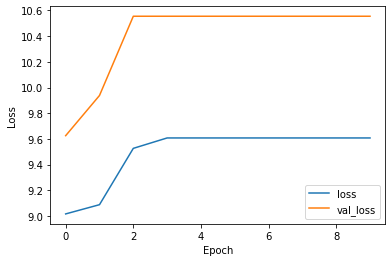

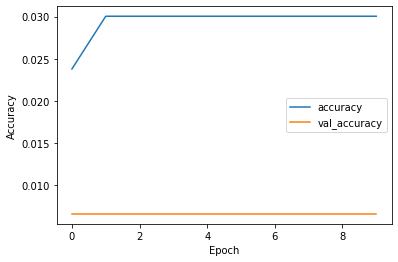

In [125]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot().set(xlabel="Epoch", ylabel="Loss")
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot().set(xlabel="Epoch", ylabel="Accuracy")

In [97]:
idx = np.random.choice(len(x_test))
sample, sample_label = x_test[idx], y_test[idx]

test_model = build_model(x_test[0].shape, NUM_CLASSES)
test_model.set_weights(model.get_weights())
result = tensorflow.argmax(test_model.predict_on_batch(tensorflow.expand_dims(sample, 0)), axis=1)
print(f'Predicted result is: {code_to_label(result)}, target result is: {code_to_label(sample_label)}, idx: {idx}')

Input shape : (19572, 1)
Output shape : 61
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 19570, 64)         256       
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 19568, 64)         12352     
_________________________________________________________________
dropout_25 (Dropout)         (None, 19568, 64)         0         
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 9784, 64)          0         
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 97, 64)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 6208)              0         
_________________________________________________________________
dense_37 (